In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from skimpy import skim

In [3]:
import tensorflow as tf
from tensorflow import keras

2022-06-19 19:34:51.267159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 19:34:51.267181: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:
from sklearn.preprocessing import StandardScaler

In [6]:
FIG_SIZE = (20, 10)
plt.rcParams.update({'figure.figsize': FIG_SIZE})   

In [4]:
df = pd.read_csv('data/TATASTEEL.csv', parse_dates=['Date'], index_col=['Date'], usecols=['Date', 'VWAP'])

<AxesSubplot:xlabel='Date'>

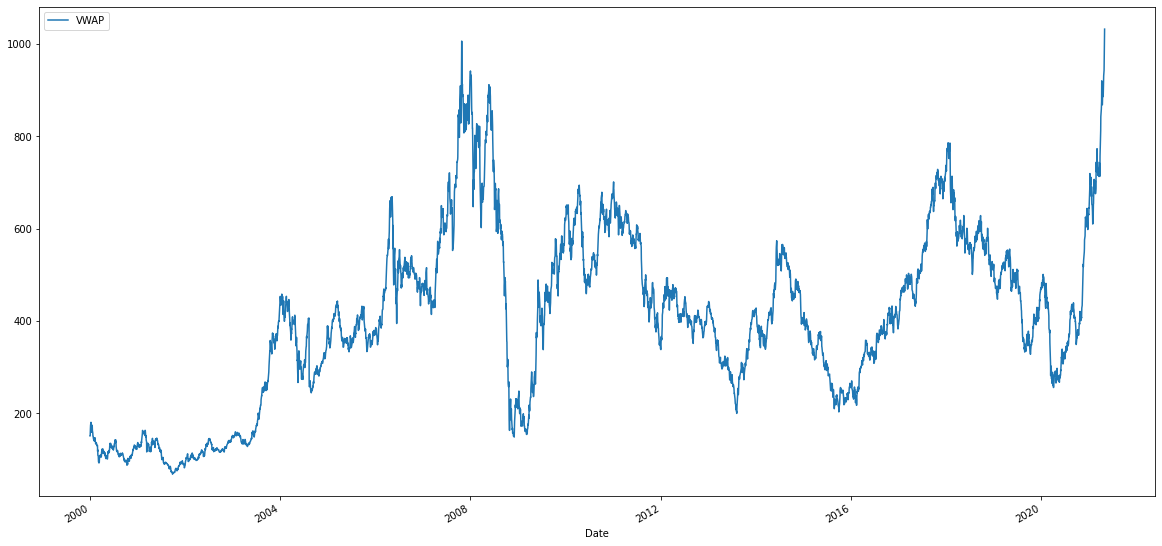

In [7]:
df.plot()

In [63]:
train_ds, valid_ds, test_ds = df.iloc[:4_000, :], df.iloc[4_000:5_000, :], df.iloc[5_000:, :]

scaler = StandardScaler()
train_ds = scaler.fit_transform(train_ds)
valid_ds = scaler.transform(valid_ds)
test_ds = scaler.transform(test_ds)

In [64]:
sequence_length = 50

In [65]:
train_ds = keras.preprocessing.timeseries_dataset_from_array(train_ds, train_ds, sequence_length=sequence_length)
valid_ds = keras.preprocessing.timeseries_dataset_from_array(valid_ds, valid_ds, sequence_length=sequence_length)
test_ds = keras.preprocessing.timeseries_dataset_from_array(test_ds, test_ds, sequence_length=sequence_length)

In [101]:
def create_simple_rnn(out_num=1):
    inputs = keras.Input(shape=(sequence_length, df.shape[-1]))
    x = keras.layers.SimpleRNN(10, return_sequences=True)(inputs)
    x = keras.layers.SimpleRNN(10)(inputs)
    outputs = keras.layers.Dense(out_num)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    return model

In [102]:
model = create_simple_rnn()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [103]:
early_stopping = keras.callbacks.EarlyStopping(min_delta=0.001, 
                                               patience=5,
                                               restore_best_weights = True)

In [104]:
model.fit(train_ds, validation_data=valid_ds, epochs=300, callbacks=[early_stopping])

Epoch 1/300
31/31 [==============================] - 1s 19ms/step - loss: 1.0786 - root_mean_squared_error: 1.0386 - val_loss: 0.4514 - val_root_mean_squared_error: 0.6718
Epoch 2/300
31/31 [==============================] - 0s 14ms/step - loss: 0.5573 - root_mean_squared_error: 0.7465 - val_loss: 0.2896 - val_root_mean_squared_error: 0.5382
Epoch 3/300
31/31 [==============================] - 0s 14ms/step - loss: 0.4035 - root_mean_squared_error: 0.6353 - val_loss: 0.2269 - val_root_mean_squared_error: 0.4764
Epoch 4/300
31/31 [==============================] - 0s 15ms/step - loss: 0.3446 - root_mean_squared_error: 0.5870 - val_loss: 0.2023 - val_root_mean_squared_error: 0.4498
Epoch 5/300
31/31 [==============================] - 0s 15ms/step - loss: 0.3087 - root_mean_squared_error: 0.5556 - val_loss: 0.1841 - val_root_mean_squared_error: 0.4291
Epoch 6/300
31/31 [==============================] - 0s 14ms/step - loss: 0.2813 - root_mean_squared_error: 0.5304 - val_loss: 0.1712 - val_

In [105]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 6ms/step - loss: 0.2021 - root_mean_squared_error: 0.4496


[0.2021445780992508, 0.44960489869117737]

In [106]:
preds_simple_rnn = model.predict(test_ds)
preds_simple_rnn = scaler.inverse_transform(preds_simple_rnn)
preds_simple_rnn = preds_simple_rnn.squeeze()

3/3 [==============================] - 0s 7ms/step


<AxesSubplot:>

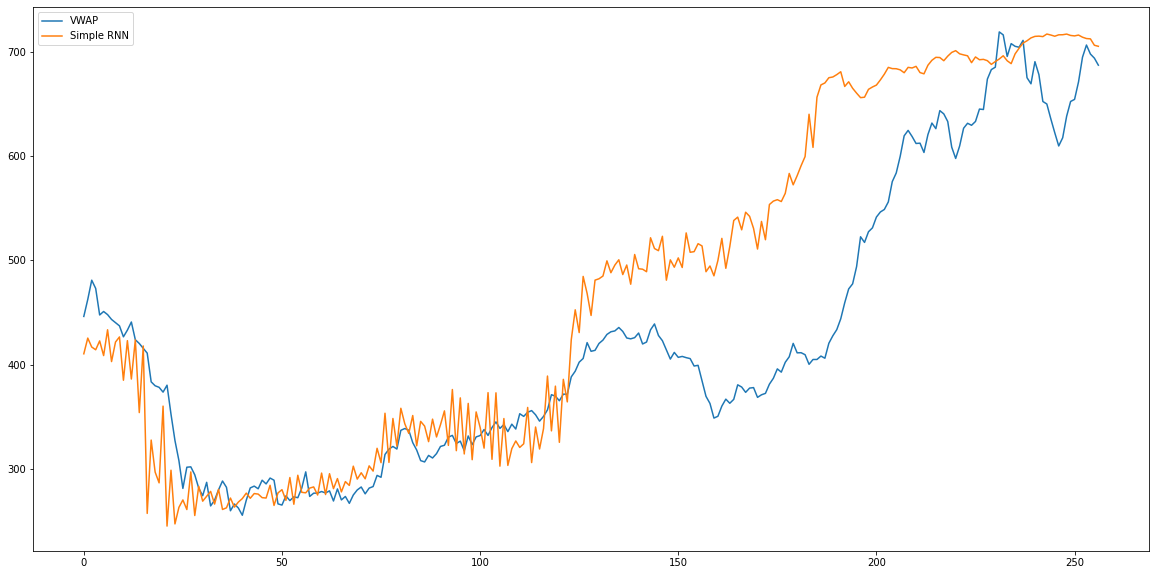

In [107]:
pd.concat([df.iloc[-preds_simple_rnn.shape[0] - sequence_length: -sequence_length, ].reset_index(drop=True),
           pd.Series(preds_simple_rnn, name='Simple RNN')], axis=1).plot()

In [108]:
def create_gru(out_num=1):
    inputs = keras.Input(shape=(sequence_length, df.shape[-1]))
    x = keras.layers.GRU(10, return_sequences=True)(inputs)
    x = keras.layers.GRU(10)(inputs)
    outputs = keras.layers.Dense(out_num)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    return model

In [109]:
model = create_gru()
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 gru_3 (GRU)                 (None, 10)                390       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.fit(train_ds, validation_data=valid_ds, epochs=300, callbacks=[early_stopping])

Epoch 1/300
31/31 [==============================] - 3s 34ms/step - loss: 0.4318 - root_mean_squared_error: 0.6571 - val_loss: 0.2293 - val_root_mean_squared_error: 0.4788
Epoch 2/300
31/31 [==============================] - 1s 24ms/step - loss: 0.2688 - root_mean_squared_error: 0.5185 - val_loss: 0.1518 - val_root_mean_squared_error: 0.3896
Epoch 3/300
31/31 [==============================] - 1s 24ms/step - loss: 0.2109 - root_mean_squared_error: 0.4592 - val_loss: 0.1293 - val_root_mean_squared_error: 0.3596
Epoch 4/300
31/31 [==============================] - 1s 24ms/step - loss: 0.1953 - root_mean_squared_error: 0.4419 - val_loss: 0.1266 - val_root_mean_squared_error: 0.3559
Epoch 5/300
31/31 [==============================] - 1s 24ms/step - loss: 0.1924 - root_mean_squared_error: 0.4386 - val_loss: 0.1265 - val_root_mean_squared_error: 0.3556
Epoch 6/300
31/31 [==============================] - 1s 24ms/step - loss: 0.1916 - root_mean_squared_error: 0.4377 - val_loss: 0.1261 - val_

In [111]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 7ms/step - loss: 0.1088 - root_mean_squared_error: 0.3299


[0.1088481992483139, 0.32992151379585266]

In [112]:
preds_gru = model.predict(test_ds)
preds_gru = scaler.inverse_transform(preds_gru)
preds_gru = preds_gru.squeeze()

3/3 [==============================] - 0s 7ms/step


<AxesSubplot:>

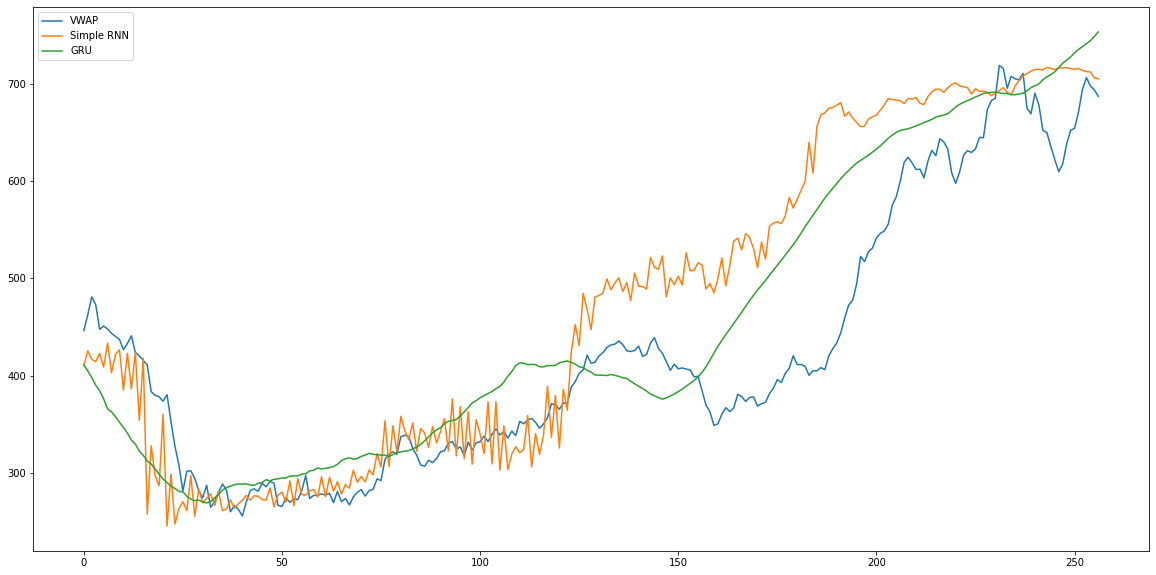

In [113]:
pd.concat([df.iloc[-preds_simple_rnn.shape[0] - sequence_length: -sequence_length, ].reset_index(drop=True),
           pd.Series(preds_simple_rnn, name='Simple RNN'), 
           pd.Series(preds_gru, name='GRU')], axis=1).plot()

In [133]:
def create_lstm(out_num=1):
    inputs = keras.Input(shape=(sequence_length, df.shape[-1]))
    x = keras.layers.LSTM(10, return_sequences=True)(inputs)
    x = keras.layers.LSTM(10)(inputs)
    outputs = keras.layers.Dense(out_num)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    return model

In [144]:
model = create_lstm()
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_11 (LSTM)              (None, 10)                480       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [145]:
decay = keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2)
early_stopping = keras.callbacks.EarlyStopping(min_delta=0.001, 
                                               patience=10,
                                               restore_best_weights = True)
model.fit(train_ds, validation_data=valid_ds, epochs=300, callbacks=[early_stopping, decay])

Epoch 1/300
31/31 [==============================] - 3s 36ms/step - loss: 0.7314 - root_mean_squared_error: 0.8552 - val_loss: 0.1774 - val_root_mean_squared_error: 0.4211 - lr: 0.0050
Epoch 2/300
31/31 [==============================] - 1s 23ms/step - loss: 0.3031 - root_mean_squared_error: 0.5506 - val_loss: 0.1410 - val_root_mean_squared_error: 0.3755 - lr: 0.0050
Epoch 3/300
31/31 [==============================] - 1s 23ms/step - loss: 0.2423 - root_mean_squared_error: 0.4922 - val_loss: 0.1288 - val_root_mean_squared_error: 0.3589 - lr: 0.0050
Epoch 4/300
31/31 [==============================] - 1s 23ms/step - loss: 0.2238 - root_mean_squared_error: 0.4730 - val_loss: 0.1228 - val_root_mean_squared_error: 0.3504 - lr: 0.0050
Epoch 5/300
31/31 [==============================] - 1s 23ms/step - loss: 0.2131 - root_mean_squared_error: 0.4616 - val_loss: 0.1216 - val_root_mean_squared_error: 0.3487 - lr: 0.0050
Epoch 6/300
31/31 [==============================] - 1s 23ms/step - loss: 0

In [146]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 8ms/step - loss: 0.1343 - root_mean_squared_error: 0.3665


[0.1343284696340561, 0.36650848388671875]

In [147]:
preds_lstm = model.predict(test_ds)
preds_lstm = scaler.inverse_transform(preds_lstm)
preds_lstm = preds_lstm.squeeze()

3/3 [==============================] - 0s 8ms/step


<AxesSubplot:>

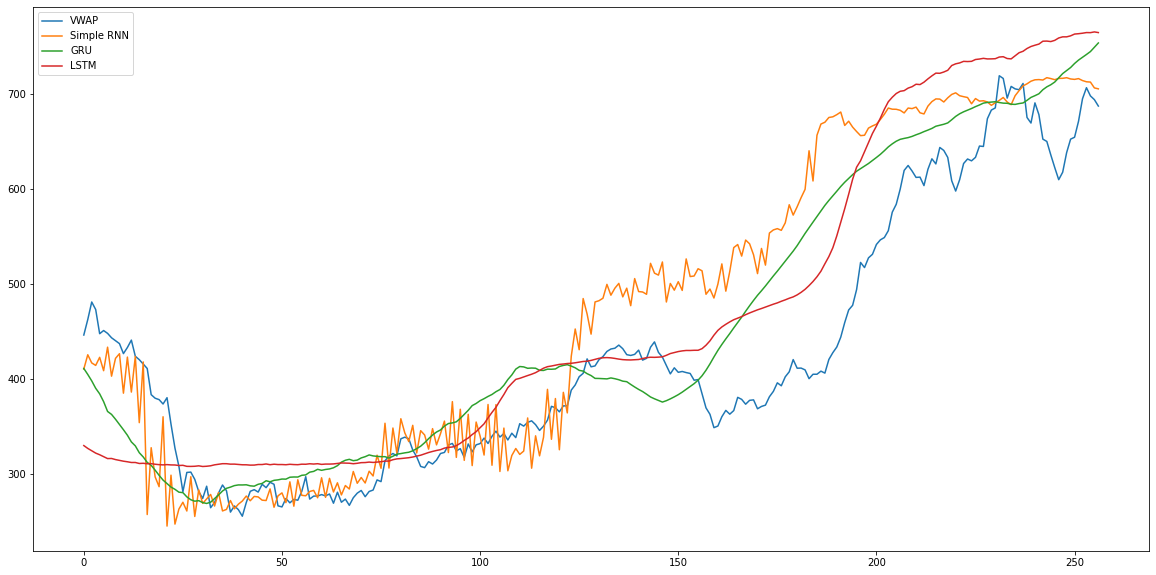

In [148]:
pd.concat([df.iloc[-preds_simple_rnn.shape[0] - sequence_length: -sequence_length, ].reset_index(drop=True),
           pd.Series(preds_simple_rnn, name='Simple RNN'), 
           pd.Series(preds_gru, name='GRU'),
           pd.Series(preds_lstm, name='LSTM')], axis=1).plot()